In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Preprocessing**

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix

Loading dataset

In [3]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  10.0M      0 --:--:-- --:--:-- --:--:-- 10.0M


Dataset Information

In [4]:
data_dir = Path("./captcha_images_v2/")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4

max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


Splitting test and train data

In [6]:
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.7, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
  

Displaying images with their labels

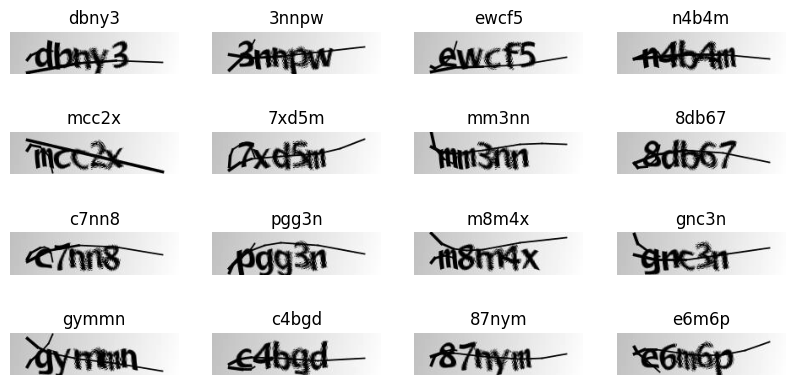

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

**RNN Model Architecture**

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Reshape input to (time_steps, feature_dimension)
    x = layers.Reshape(target_shape=(img_width, img_height))(input_img)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_rnn")

    # Optimizer
    opt = keras.optimizers.Adam()

    # Compile the model and return
    model.compile(optimizer=opt)
    return model

In [10]:
# Get the model
model = build_model()
model.summary()

Model: "ocr_model_rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape (Reshape)              (None, 200, 50)      0           ['image[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 256)     183296      ['reshape[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 200, 128)    164352      ['bidirectional[0][0]

Training the RNN Model

In [40]:
epochs = 1 #40 epochs
early_stopping_patience = 10

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
)

46/46 [==============================] - 20s 433ms/step - loss: 1.6666 - val_loss: 0.8490


In [45]:
model.save('/content/rnn_model.h5')
!cp /content/rnn_model.h5 /content/drive/My\ Drive/rnn_model.h5

**Predictions**

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 reshape (Reshape)           (None, 200, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         183296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 128)         164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 200, 21)           2709      
                                                                 
Total params: 350,357
Trainable params: 350,357
Non-trainab

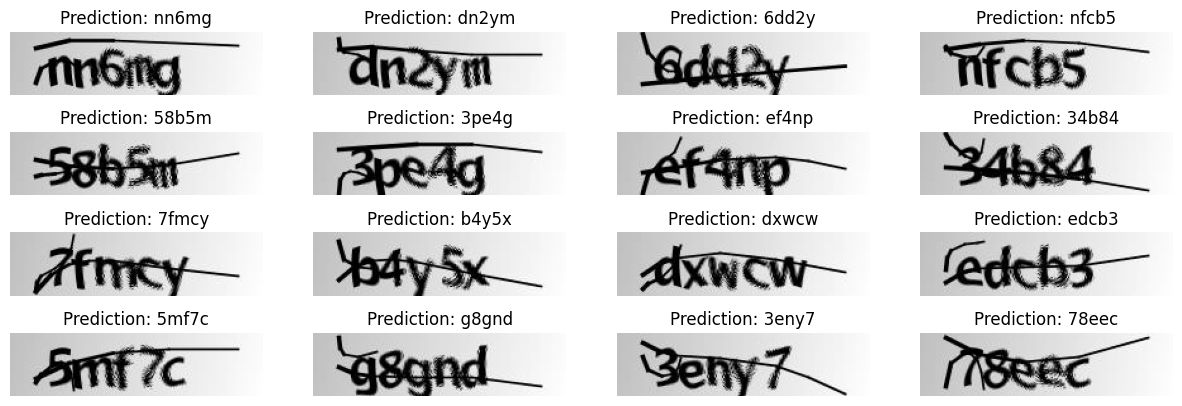

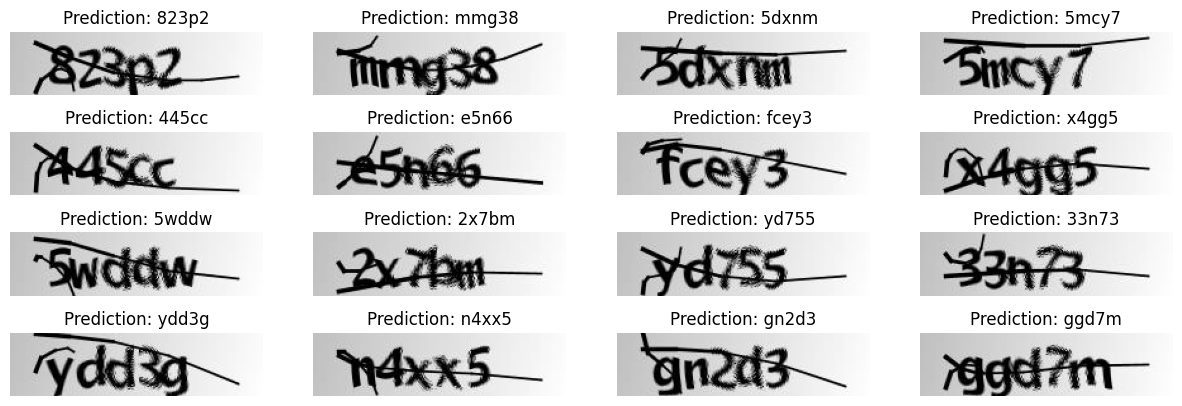

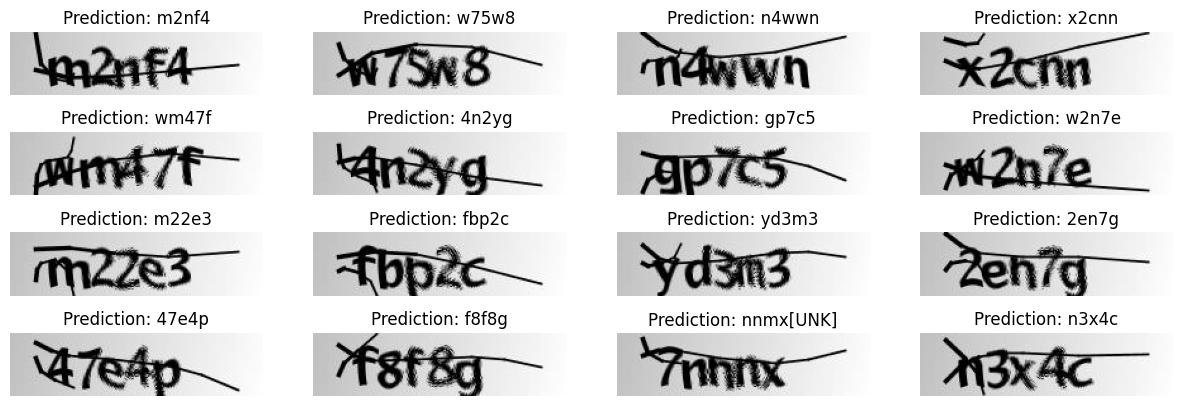

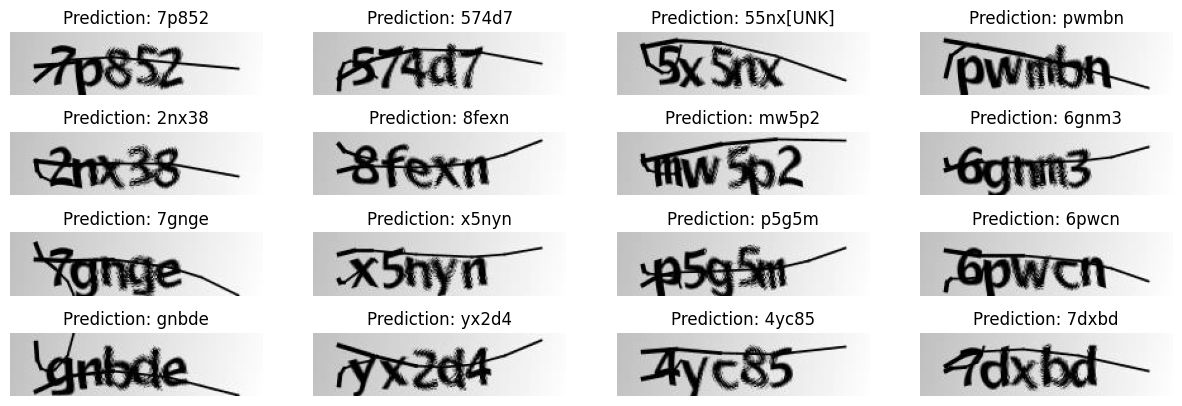

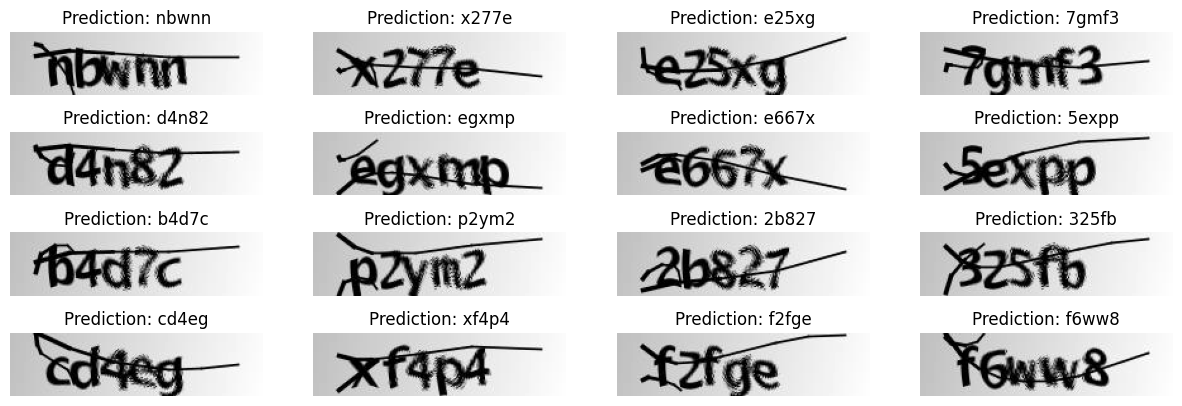

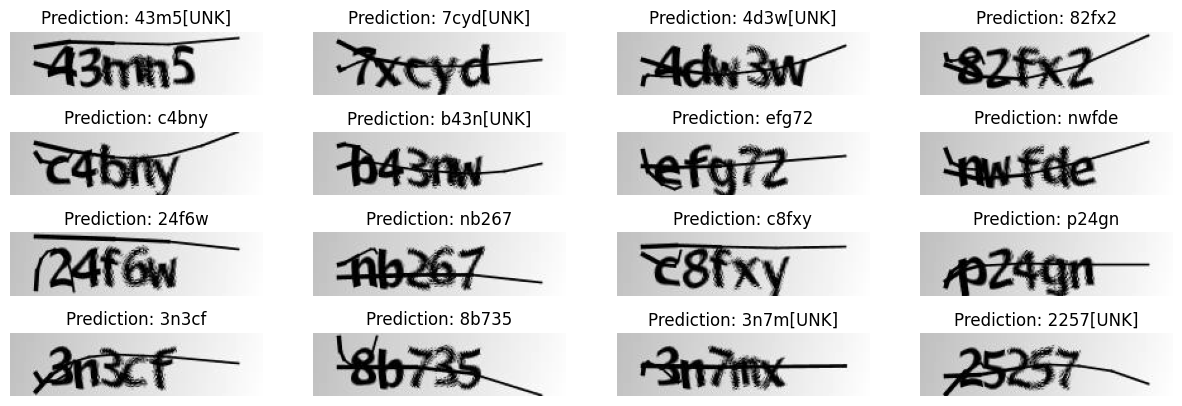

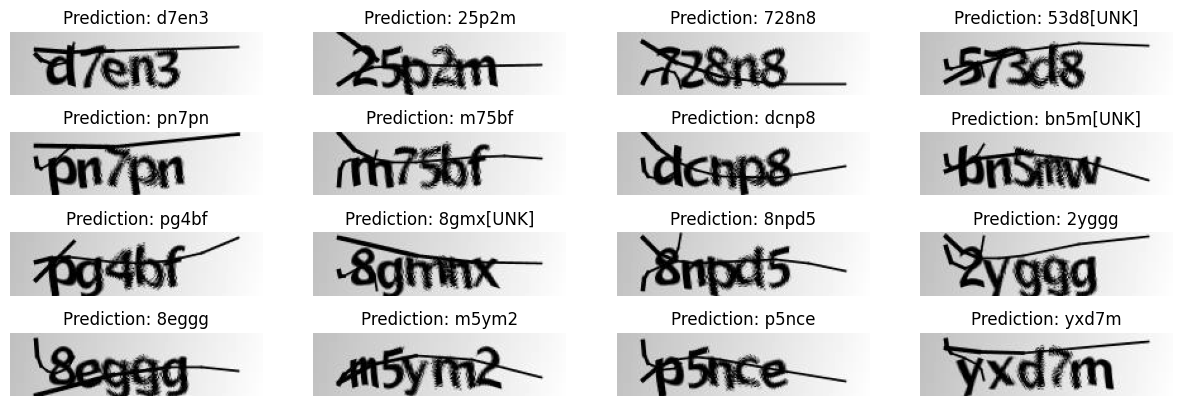

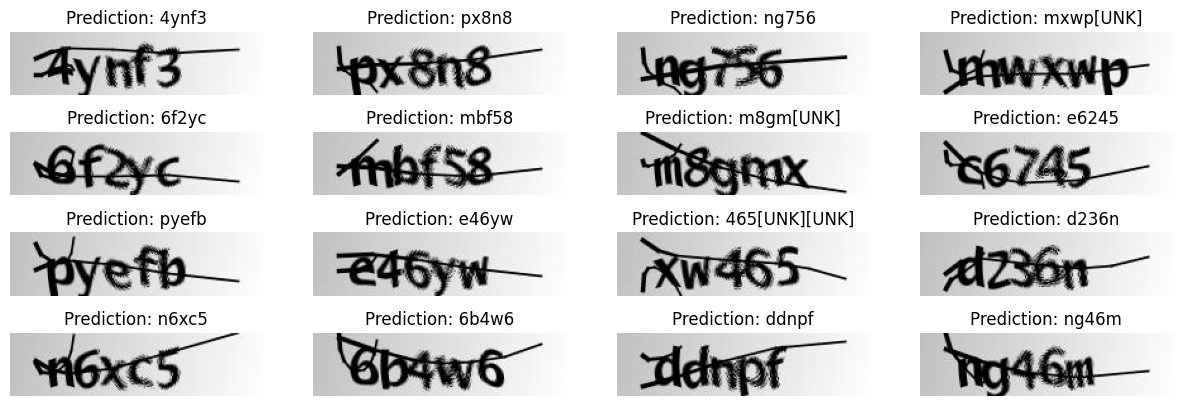

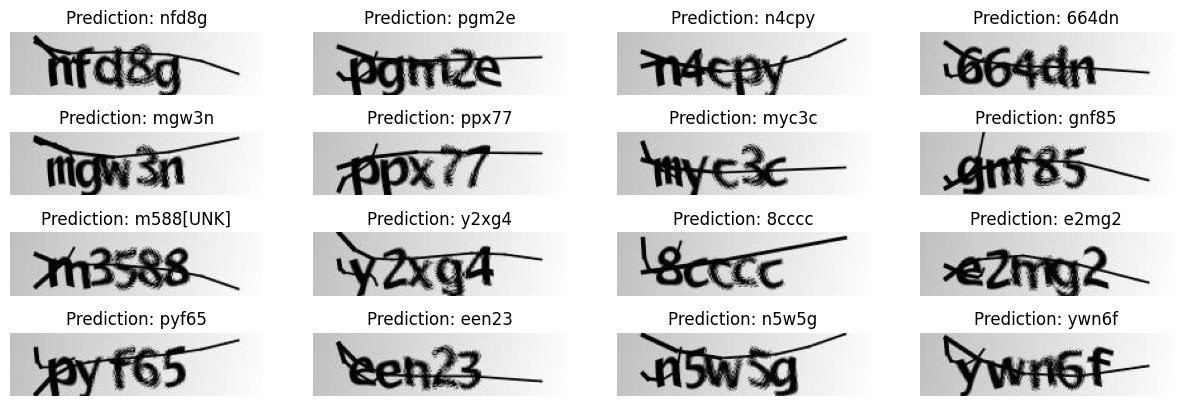

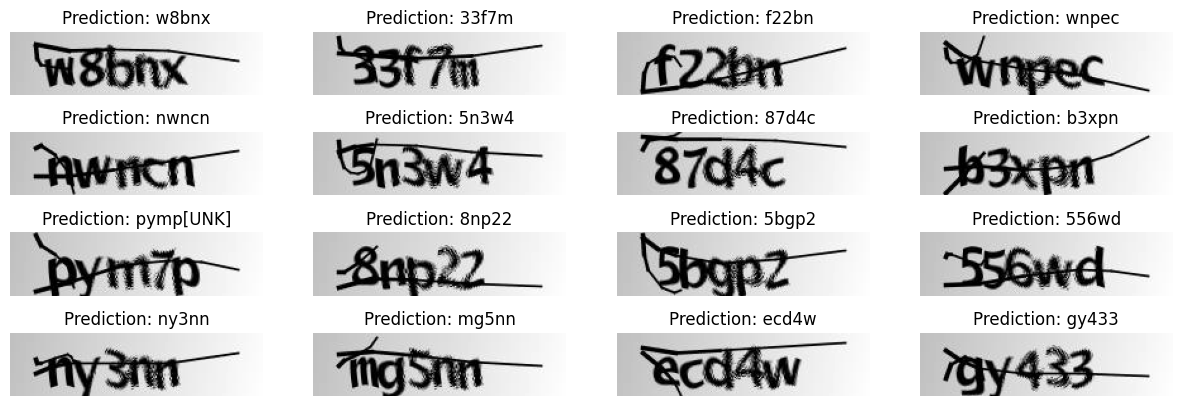

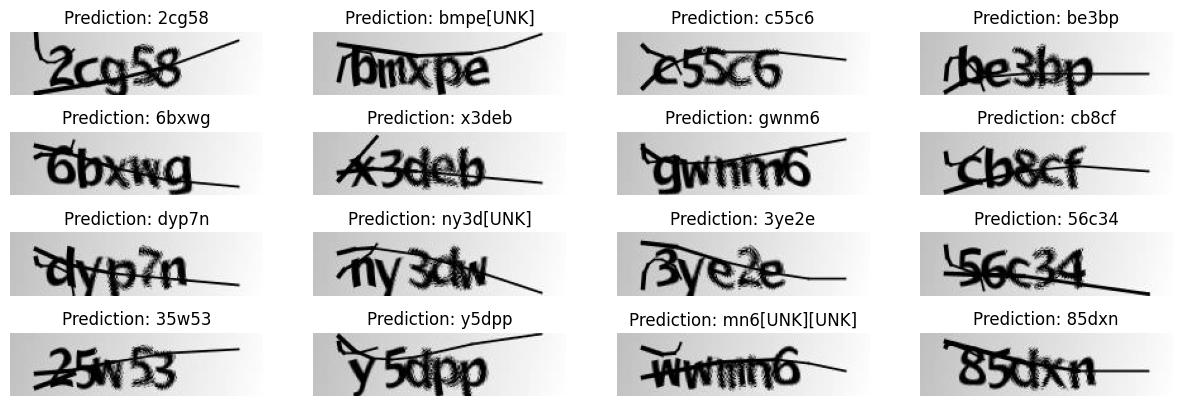

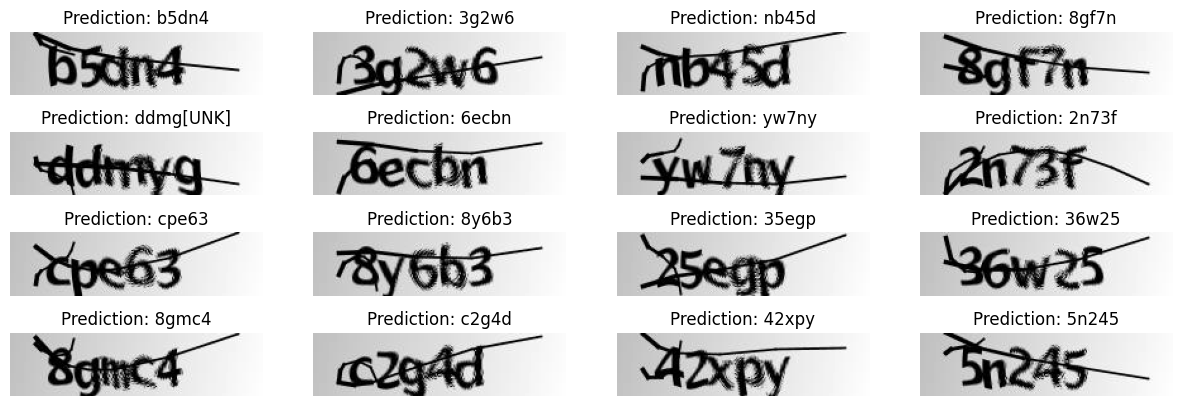

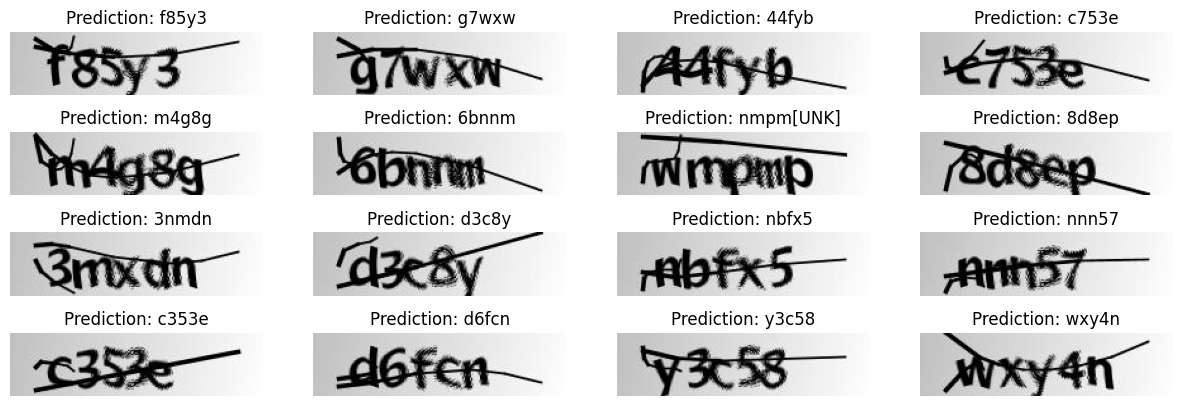

In [48]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

prediction = []
original_texts = []
#  Let's check results on some validation samples
for batch in validation_dataset.take(13):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    prediction.append(pred_texts)

    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        original_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [49]:
print(prediction)

[['nn6mg', 'dn2ym', '6dd2y', 'nfcb5', '58b5m', '3pe4g', 'ef4np', '34b84', '7fmcy', 'b4y5x', 'dxwcw', 'edcb3', '5mf7c', 'g8gnd', '3eny7', '78eec'], ['823p2', 'mmg38', '5dxnm', '5mcy7', '445cc', 'e5n66', 'fcey3', 'x4gg5', '5wddw', '2x7bm', 'yd755', '33n73', 'ydd3g', 'n4xx5', 'gn2d3', 'ggd7m'], ['m2nf4', 'w75w8', 'n4wwn', 'x2cnn', 'wm47f', '4n2yg', 'gp7c5', 'w2n7e', 'm22e3', 'fbp2c', 'yd3m3', '2en7g', '47e4p', 'f8f8g', 'nnmx[UNK]', 'n3x4c'], ['7p852', '574d7', '55nx[UNK]', 'pwmbn', '2nx38', '8fexn', 'mw5p2', '6gnm3', '7gnge', 'x5nyn', 'p5g5m', '6pwcn', 'gnbde', 'yx2d4', '4yc85', '7dxbd'], ['nbwnn', 'x277e', 'e25xg', '7gmf3', 'd4n82', 'egxmp', 'e667x', '5expp', 'b4d7c', 'p2ym2', '2b827', '325fb', 'cd4eg', 'xf4p4', 'f2fge', 'f6ww8'], ['43m5[UNK]', '7cyd[UNK]', '4d3w[UNK]', '82fx2', 'c4bny', 'b43n[UNK]', 'efg72', 'nwfde', '24f6w', 'nb267', 'c8fxy', 'p24gn', '3n3cf', '8b735', '3n7m[UNK]', '2257[UNK]'], ['d7en3', '25p2m', '728n8', '53d8[UNK]', 'pn7pn', 'm75bf', 'dcnp8', 'bn5m[UNK]', 'pg4bf', '

In [50]:
print(original_texts)

['nn6mg', 'dn2ym', '6dd2y', 'nfcb5', '58b5m', '3pe4g', 'ef4np', '34b84', '7fmcy', 'b4y5x', 'dxwcw', 'cdcb3', '5mf7c', 'g8gnd', '3eny7', '78eec', '823p2', 'mmg38', '5dxnm', '5mcy7', '445cc', 'e5n66', 'fcey3', 'x4gg5', '5wddw', '2x7bm', 'yd755', '33n73', 'ydd3g', 'n4xx5', 'gn2d3', 'ggd7m', 'm2nf4', 'w75w8', 'n4wwn', 'x2cnn', 'wm47f', '4n2yg', 'gp7c5', 'w2n7e', 'm22e3', 'fbp2c', 'yd3m3', '2en7g', '47e4p', 'f8f8g', '7nnnx', 'n3x4c', '7p852', '574d7', '5x5nx', 'pwmbn', '2nx38', '8fexn', 'mw5p2', '6gnm3', '7gnge', 'x5nyn', 'p5g5m', '6pwcn', 'gnbde', 'yx2d4', '4yc85', '7dxbd', 'nbwnn', 'x277e', 'e25xg', '7gmf3', 'd4n82', 'egxmp', 'e667x', '5expp', 'b4d7c', 'p2ym2', '2b827', '325fb', 'cd4eg', 'xf4p4', 'f2fge', 'f6ww8', '43mn5', '7xcyd', '4dw3w', '82fx2', 'c4bny', 'b43nw', 'efg72', 'nwfde', '24f6w', 'nb267', 'c8fxy', 'p24gn', '3n3cf', '8b735', '3n7mx', '25257', 'd7en3', '25p2m', '728n8', '573d8', 'pn7pn', 'm75bf', 'dcnp8', 'bn5mw', 'pg4bf', '8gmnx', '8npd5', '2yggg', '8eggg', 'm5ym2', 'p5nce', 

In [54]:
#Predicted Texts
pred = []
for arr in prediction:
  for i in arr:
    pred.append(i)

Accuracy

In [51]:
correct = 0
for i in original_texts:
  for batch in prediction:
    for j in batch:
      if i == j:
        correct = correct + 1
accuracy = correct/ 312
print(accuracy)

0.5833333333333334
